In [23]:
import torchvision
import torch
from torchvision import transforms
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
import numpy as np
import datetime

writer = SummaryWriter("runs")
image_path = "./"
transform = transforms.Compose([transforms.ToTensor()])

mnist_dataset = torchvision.datasets.MNIST(
    root=image_path, train=True, transform=transform, download=True
)

from torch.utils.data import Subset

mnist_valid_dataset = Subset(mnist_dataset, torch.arange(10000))
mnist_train_dataset = Subset(mnist_dataset, torch.arange(10000, len(mnist_dataset)))
mnist_test_dataset = torchvision.datasets.MNIST(
    root=image_path, train=False, transform=transform, download=False
)

In [24]:
from torch.utils.data import DataLoader


batch_size = 64
torch.manual_seed(1)
train_dl = DataLoader(mnist_train_dataset, batch_size, shuffle=True)
valid_dl = DataLoader(mnist_valid_dataset, batch_size, shuffle=False)

In [25]:
# Model Definition
import torch.nn as nn

model = nn.Sequential()
model.add_module(
    "conv1", nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, padding=2)
)
# in_channels = 1 because it's just grayscale
"""out_channels = 32 because there are 32 filters (kernels) applied to each image in a batch which results
    in 32 different feature maps for each image"""
model.add_module("relu1", nn.ReLU())
model.add_module("pool1", nn.MaxPool2d(kernel_size=2))
model.add_module(
    "conv2", nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding=2)
)
model.add_module("relu2", nn.ReLU())
model.add_module("pool2", nn.MaxPool2d(kernel_size=2))

model.add_module("flatten", nn.Flatten())
model.add_module("fc1", nn.Linear(3136, 1024))
model.add_module("relu3", nn.ReLU())
model.add_module("dropout", nn.Dropout(p=0.5))

model.add_module("fc2", nn.Linear(1024, 10))

In [26]:
model

Sequential(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=3136, out_features=1024, bias=True)
  (relu3): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=1024, out_features=10, bias=True)
)

In [31]:
writer = SummaryWriter()

images, labels = next(iter(train_dl))
grid = torchvision.utils.make_grid(images)
writer.add_image("images", grid, 0)
writer.add_graph(model, images)
writer.close()

In [34]:
# Train Model
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


def train(model, num_epochs, train_dl, valid_dl):
    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs
    for epoch in range(num_epochs):
        model.train()
        for x_batch, y_batch in train_dl:
            pred = model(x_batch)
            loss = loss_fn(pred, y_batch)
            writer.add_scalar("Loss/train", loss, epoch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            loss_hist_train[epoch] += loss.item() * y_batch.size(0)
            is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
            accuracy_hist_train[epoch] += is_correct.sum().cpu()
            writer.add_scalar("Accuracy_Train", accuracy_hist_train[epoch], epoch)

        loss_hist_train[epoch] /= len(train_dl.dataset)
        accuracy_hist_train[epoch] /= len(train_dl.dataset)

        model.eval()
        with torch.no_grad():
            for x_batch, y_batch in valid_dl:
                pred = model(x_batch)
                loss = loss_fn(pred, y_batch)
                writer.add_scalar("Loss/test", loss, epoch)
                loss_hist_valid[epoch] += loss.item() * y_batch.size(0)
                is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
                accuracy_hist_valid[epoch] += is_correct.sum().cpu()
                writer.add_scalar(
                    "Accuracy_Validation", accuracy_hist_valid[epoch], epoch
                )

        loss_hist_valid[epoch] /= len(valid_dl.dataset)
        accuracy_hist_valid[epoch] /= len(valid_dl.dataset)

        print(
            f"Epoch {epoch+1} accuracy: {accuracy_hist_train[epoch]:.4f}, val_accuracy: {accuracy_hist_valid[epoch]:.4f}"
        )
    return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid


torch.manual_seed(1)
num_epochs = 5
hist = train(model, num_epochs, train_dl, valid_dl)
writer.flush()
writer.close()

Epoch 1 accuracy: 0.9954, val_accuracy: 0.9893
Epoch 2 accuracy: 0.9955, val_accuracy: 0.9892
Epoch 3 accuracy: 0.9969, val_accuracy: 0.9888
Epoch 4 accuracy: 0.9973, val_accuracy: 0.9911
Epoch 5 accuracy: 0.9970, val_accuracy: 0.9870


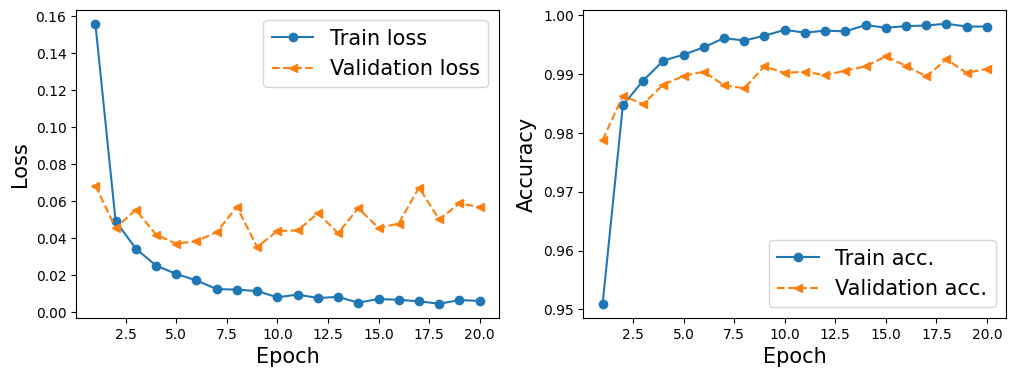

In [12]:
import matplotlib.pyplot as plt
import numpy as np


x_arr = np.arange(len(hist[0])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist[0], "-o", label="Train loss")
ax.plot(x_arr, hist[1], "--<", label="Validation loss")
ax.set_xlabel("Epoch", size=15)
ax.set_ylabel("Loss", size=15)
ax.legend(fontsize=15)
ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist[2], "-o", label="Train acc.")
ax.plot(x_arr, hist[3], "--<", label="Validation acc.")
ax.legend(fontsize=15)
ax.set_xlabel("Epoch", size=15)
ax.set_ylabel("Accuracy", size=15)

plt.show()